In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments
import torch

import matplotlib.pyplot as plt
import seaborn as sns

# 1.0 Load Data

In [2]:
df = pd.read_parquet("input_data/ccd_full.parquet")
print(df.shape)
display(df.head())                    

(25829, 3)


text  label label_name
0                      i am still waiting on my card      1   negative
1  what can i do if my card still hasnt arrived a...      1   negative
2  i have been waiting over a week is the card st...      1   negative
3  can i track my card while it is in the process...      2    neutral
4  how do i know if i will get my card or if it i...      2    neutral

In [3]:
# testing - check for duplicates or errors in labels
sorted(df['label_name'].unique())

['negative', 'neutral', 'positive', 'very negative', 'very positive']

# 2.0 EDA

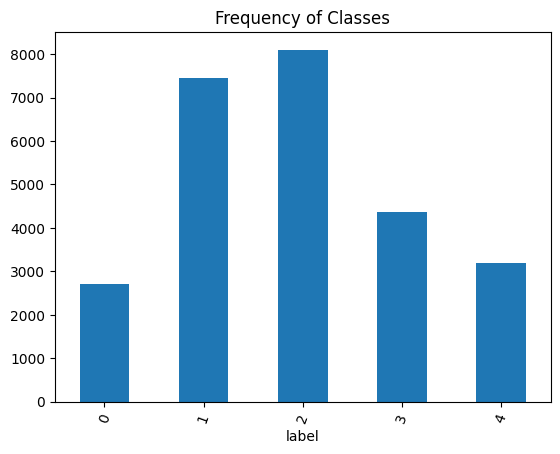

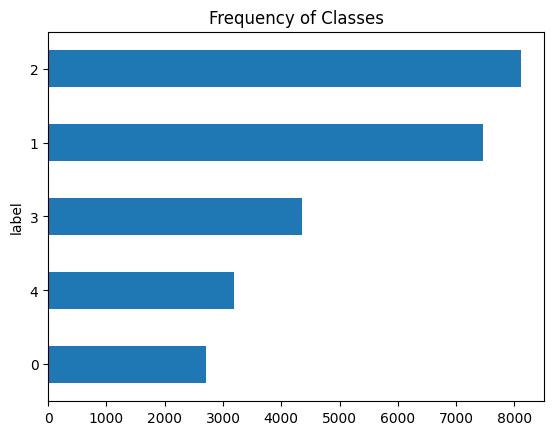

In [4]:
# testing - check for duplicates or errors in labels
plt.title("Frequency of Classes")
df['label'].value_counts().sort_index().plot(kind='bar', rot=70)
plt.show()

plt.title("Frequency of Classes")
df['label'].value_counts(ascending=True).plot.barh()
plt.show()

In [5]:
df.columns

Index(['text', 'label', 'label_name'], dtype='object')

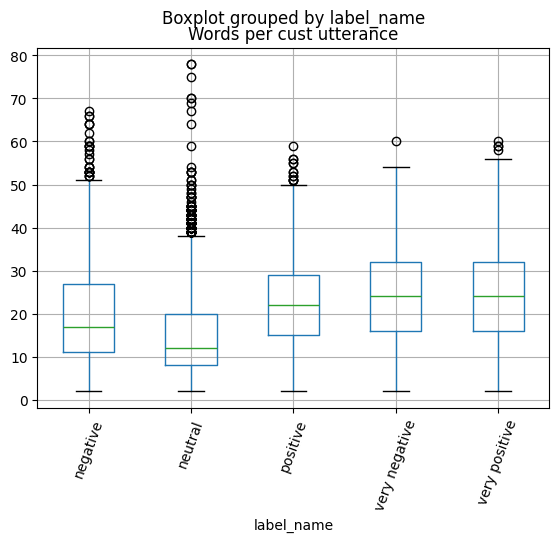

In [6]:
aa = pd.DataFrame()
aa['Words per cust utterance'] = df['text'].str.split().apply(len)
aa['label_name'] = df['label_name'].copy()
aa.boxplot("Words per cust utterance", by="label_name", rot=70)
plt.show()

# 3.0 Data Prep

### 3.1 Remove columns that are not required for training this model
We only want:
- 'text' aka Feature X
- 'sentiment' aka Target y

In [7]:
# dft = df[['text', 'sentiment']].copy()
# dft.rename(columns={'sentiment': 'label_name'}, inplace=True)
# display(dft.head(3))
# print()

In [8]:
dft = df.copy()
del df
print(dft.shape)
print(dft['label_name'].unique())
display(dft.head(3))
display(dft.tail(3))

(25829, 3)
['negative' 'neutral' 'very negative' 'positive' 'very positive']


text  label label_name
0                      i am still waiting on my card      1   negative
1  what can i do if my card still hasnt arrived a...      1   negative
2  i have been waiting over a week is the card st...      1   negative

text  label     label_name
25826  a film made with as little wit , interest , an...      1       negative
25827  to enjoy this movie 's sharp dialogue and deli...      2        neutral
25828  but here 's the real damn : it is n't funny , ...      0  very negative

### 3.2 Define `label2id` and `id2label`

In [9]:
label_name = sorted(dft['label_name'].unique())
label = [i for i in range(len(label_name))]

label2id = {lbl_name: lbl for lbl_name, lbl in zip(label_name, label)}
id2label = {lbl: lbl_name for lbl_name, lbl in zip(label_name, label)}
for k, v in label2id.items():
    print(f"{str(k):15}", ' --- ', v)
# for k, v in id2label.items():
#     print(f"{str(k):15}", ' --- ', v)

negative         ---  0
neutral          ---  1
positive         ---  2
very negative    ---  3
very positive    ---  4


### 3.3 Create column to Hold Label as Integer

In [10]:
# dft['label'] =dft['label_name'].apply(lambda x: label2id[x])
# dft = dft[['text', 'label', 'label_name']]
# dft.sample(5)

### 3.4 Create `train`, `validation`, and `test` datasets

In [11]:
train, test = train_test_split(dft, test_size=0.3, stratify=dft['label_name'], random_state=42)
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'], random_state=42)

train.shape, validation.shape, test.shape

((18080, 3), (2583, 3), (5166, 3))

### 3.5 Convert to HF Dataset

In [12]:
dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 18080
    })
    test: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 5166
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 2583
    })
})

In [13]:
# # model_ckpt = "distilbert-base-uncased"
# model_ckpt = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


# text = "I love machine learning! Tokenization is awesome!!"
# encoded_text = tokenizer(text)
# print(encoded_text)

In [14]:
# len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

# 4.0 Tokenise Data

### 4.1 Load Tokenizers
- distilbert-base-uncased
- google/mobilebert-uncased
- huawei-noah/TinyBERT_General_4L_312D

In [15]:
# from transformers import AutoTokenizer

# model_ckpt = "distilbert-base-uncased"
# distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# print(distilbert_tokenizer, '\n')

# model_ckpt = "google/mobilebert-uncased"
# mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# print(mobilebert_tokenizer, '\n')

# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
# tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# print(tinybert_tokenizer, '\n')

### 4.2 Tokenize Functions

In [16]:
# def tokenize(tokenizer_model, batch, col_name: str):
#     """
#     returns the tokenised batch
#     """
#     return tokenizer_model(batch[col_name], padding=True, truncation=True)

# print(tokenize(
#     tokenizer_model = distilbert_tokenizer, 
#     batch=dataset['train'][:2], 
#     col_name='text')
# )

In [17]:
# def batch_tokenize_distilbert(batch):
#     return distilbert_tokenizer(batch['text'], padding=True, truncation=True)
#     return temp

# print(batch_tokenize_distilbert(dataset['train'][:2]))

In [18]:
# testing the function
# encoded_dataset = dataset.map(batch_tokenize_distilbert, batch_size=None, batched=True)

In [19]:
# del encoded_dataset

# 5.0 Build Multiple Models

In [20]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_col_name = 'text'

model_dict = {
    # "bert-base": "bert-base-uncased",
    # "distilbert": "distilbert-base-uncased",
    # "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        return tokenizer(batch[feature_col_name], padding=True, truncation=True)
    
    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )
    
    trainer.train()
    
    local_repo_model_name = f"model_trained/{model_name}"
    trainer.save_model(local_repo_model_name)

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics
    

import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()
    
    model_performance[model_name] = {model_name:result, "time taken": end-start}




Training Model:  tinybert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/18080 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5166 [00:00<?, ? examples/s]

Map:   0%|          | 0/2583 [00:00<?, ? examples/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
model_performance

{'tinybert': {'tinybert': {'test_loss': 0.8083325028419495,
   'test_accuracy': 0.6699574138598529,
   'test_f1': 0.6698682678441236,
   'test_runtime': 3.0766,
   'test_samples_per_second': 1679.149,
   'test_steps_per_second': 209.975},
  'time taken': 140.47650003433228}}

# 6.0 Load from Local and Predict
- "bert-base": "bert-base-uncased",
- "distilbert": "distilbert-base-uncased",
- "mobilebert": "google/mobilebert-uncased",
- "tinybert": "huawei-noah/TinyBERT_General_4L_312D"


In [23]:
# local_repo_model_name = "model_trained/distilbert"
local_repo_model_name = "model_trained/tinybert"
# local_repo_model_name = "model_trained/mobilebert"  # chk spelling

In [24]:
input_text = ["please tell me more about your fixed deposit.", 
              "your savings rate is terrible!",
             "Yay! I have finally paid off my loan!"]

In [25]:
# use pipeline for prediciton
from transformers import pipeline

clf = pipeline('text-classification', model=local_repo_model_name)

response = clf(input_text)
response

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'positive', 'score': 0.8991588354110718},
 {'label': 'negative', 'score': 0.9362162351608276},
 {'label': 'very negative', 'score': 0.6220074892044067}]

# 7.0 Upload from local to HF Hub

### 7.1 Set Credentials

In [26]:
from huggingface_hub import notebook_login
notebook_login()

### 7.2 Create a new HF Repo if required

In [27]:
hf_repo_model_name = "richardchai/plp_sentiment_clr_tinybert"  # i.e. "your-username/your-model-name"

from huggingface_hub import HfApi
api = HfApi()
api.create_repo(repo_id=hf_repo_model_name)

RepoUrl('https://huggingface.co/richardchai/plp_sentiment_clr_tinybert', endpoint='https://huggingface.co', repo_type='model', repo_id='richardchai/plp_sentiment_clr_tinybert')

In [28]:
local_repo_model_name

'model_trained/tinybert'

In [29]:
hf_repo_model_name

'richardchai/plp_sentiment_clr_tinybert'

7.3 Upload to HF Hub - Model and Tokenizer

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(local_repo_model_name)
tokenizer = AutoTokenizer.from_pretrained(local_repo_model_name)

# Push the model and tokenizer to Hugging Face Hub
model.push_to_hub(hf_repo_model_name)
tokenizer.push_to_hub(hf_repo_model_name)

### 7.4 Upload to HF Hub - Model Card

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
language: en
license: mit
---

# Model Card
Bank Sentiment Classifier - tinyBERT
Developed by: Richard Chai, https://www.linkedin.com/in/richardchai/

This model has been fine-tuned for Bank User Sentiment Identification.
Currently, it identifies the following Sentiment:
{
 'very negative': 0,
 'negative': 1,
 'neutral': 2,
 'positive': 3,
 'very positive': 4
}

## Model Details
- **Model type**: Transformer-based (e.g., BERT, DistilBERT, etc.): tinyBERT
- **Dataset**: Stanford Sentiment Treebank SST-5 or another sentiment dataset
- **Fine-tuning**: The model was fine-tuned for X epochs using a learning rate of Y on a dataset with Z samples.


## Usage
You can use this model to classify text sentiment as follows:

```python
from transformers import pipeline

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

model_checkpt = "{hf_repo_model_name}"
clf = pipeline('text-classification', model="{local_repo_model_name}", device=device)
result = clf(f"{input_text}")
print(result)
```

"""

card = ModelCard(content)
card.push_to_hub(hf_repo_model_name)

# 8.0 Download from HF Hub and Predict
Uploaded to HF Hub:
- https://huggingface.co/richardchai/plp_sentiment_clr_distilbert

In [ ]:
hf_repo_model_name

In [ ]:
from transformers import pipeline

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

clf = pipeline('text-classification', model=hf_repo_model_name, device=device)
result = clf(input_text)
print('\n', result)